In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


from xgboost import XGBRegressor, XGBClassifier

import optuna

/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRIALS = 100

In [3]:
df_matches = pd.read_csv("matches.csv")

## Baseline Models

In [4]:
class StaticEstimator(BaseEstimator):
    def __init__(self, result) -> None:
        super().__init__()
        self.result = result

    def fit(self, X, y):
        pass

    def predict(self, X):
        results = np.zeros((len(X), 2))
        results[:] = self.result
        return results

class RandomEstimator(BaseEstimator):
    
    def fit(self, X, y):
        df_result_counts = df_matches[["host_goals", "guest_goals"]].value_counts().reset_index()
        df_result_counts["p"] = df_result_counts["count"] / len(df_matches)
        self.df_result_counts = df_result_counts

    def predict(self, X):
        df_result_counts = self.df_result_counts
        result_indices = np.random.choice(df_result_counts.index, len(X), p=df_result_counts["p"].values)
        return df_result_counts.loc[result_indices, ["host_goals", "guest_goals"]].values

0:0: 187.69 +- 17.45
1:1: 223.38 +- 17.01
1:0: 354.46 +- 25.95
0:1: 245.77 +- 20.83
random: 271.77 +- 17.17


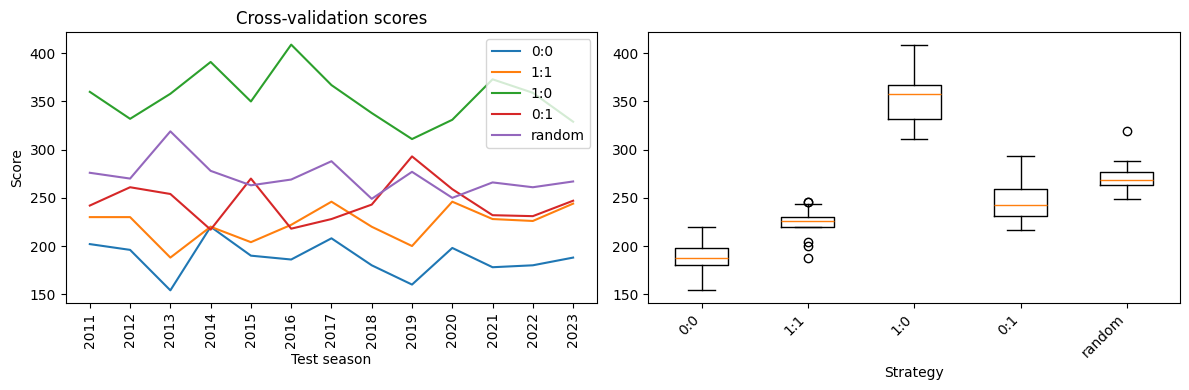

In [5]:
from utils import cross_val_splits, kicktipp_scoring


def evaluate_simple_models(scoring):
    splits = cross_val_splits(df_matches)
    labels = df_matches[["host_goals", "guest_goals"]].values
    static_results = [[0, 0], [1, 1], [1, 0], [0, 1]]
    static_result_scores = []
    for result in static_results:
        scores = cross_val_score(StaticEstimator(result), df_matches, labels, cv=splits, scoring=scoring)
        static_result_scores.append(scores)
    static_result_scores = np.array(static_result_scores)

    random_scores = cross_val_score(RandomEstimator(), df_matches, labels, cv=splits, scoring=scoring)

    all_scores = np.vstack((static_result_scores, random_scores))
    labels = [f"{res[0]}:{res[1]}" for res in static_results] + ["random"]
    for score, label in zip(all_scores, labels):
        print(f"{label}: {score.mean():.2f} +- {score.std():.2f}")

    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    split_test_seasons = [df_matches.iloc[split[1][0]]["season"] for  split in splits]
    axs[0].plot(all_scores.T, label=labels)
    axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
    axs[0].set_xlabel("Test season")
    axs[0].set_ylabel("Score")
    axs[0].legend()
    axs[0].set_title("Cross-validation scores")

    axs[1].boxplot(all_scores.T)
    axs[1].set_xlabel("Strategy")
    axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=45, ha="right")
    fig.tight_layout()

evaluate_simple_models(scoring=kicktipp_scoring)

# Matches with team context

In [6]:
df_full = pd.read_csv("matches_with_context.csv", index_col="id")
df_full = df_full.fillna(0)
df_full.tail()

,match_day,season,host_id,host_name,guest_id,guest_name,host_goals,guest_goals,host_last_season_draws,host_last_season_goal_diff,...,host_horizon_wins,host_horizon_draws,host_horizon_defeats,guest_horizon_points,guest_horizon_goals,guest_horizon_opponent_goals,guest_horizon_goal_diff,guest_horizon_wins,guest_horizon_draws,guest_horizon_defeats
id,,,,,,,,,,,,,,,,,,,,,
66932,34,2023,131,Wolfsburg,81,Mainz,1,3,10.0,9.0,...,14.000000,8.666667,11.333333,43.666667,47.666667,52.000000,-4.333333,11.666667,8.666667,13.666667
66933,34,2023,175,Hoffenheim,40,Bayern,4,2,6.0,-9.0,...,11.333333,7.666667,15.000000,75.333333,96.000000,39.666667,56.333333,23.000000,6.333333,4.666667
66934,34,2023,134,Bremen,129,Bochum,4,1,6.0,-13.0,...,8.500000,8.000000,17.500000,38.500000,39.000000,62.000000,-23.000000,11.000000,5.500000,17.500000
66935,34,2023,16,Stuttgart,87,Gladbach,4,0,12.0,-12.0,...,8.666667,11.000000,14.333333,45.666667,56.666667,57.333333,-0.666667,12.000000,9.666667,12.333333
66936,34,2023,199,Heidenheim,65,Köln,4,1,0.0,0.0,...,0.000000,0.000000,0.000000,42.333333,45.000000,54.333333,-9.333333,10.666667,10.333333,13.000000


In [7]:
X_all = df_full.drop(columns=["host_name", "guest_name", "host_goals", "guest_goals"])
y_all = df_full[["host_goals", "guest_goals"]].values
print(X_all.columns)

Index(['match_day', 'season', 'host_id', 'guest_id', 'host_last_season_draws',
       'host_last_season_goal_diff', 'host_last_season_goals',
       'host_last_season_defeats', 'host_last_season_matches',
       'host_last_season_opponent_goals', 'host_last_season_points',
       'host_last_season_wins', 'guest_last_season_draws',
       'guest_last_season_goal_diff', 'guest_last_season_goals',
       'guest_last_season_defeats', 'guest_last_season_matches',
       'guest_last_season_opponent_goals', 'guest_last_season_points',
       'guest_last_season_wins', 'host_horizon_points', 'host_horizon_goals',
       'host_horizon_opponent_goals', 'host_horizon_goal_diff',
       'host_horizon_wins', 'host_horizon_draws', 'host_horizon_defeats',
       'guest_horizon_points', 'guest_horizon_goals',
       'guest_horizon_opponent_goals', 'guest_horizon_goal_diff',
       'guest_horizon_wins', 'guest_horizon_draws', 'guest_horizon_defeats'],
      dtype='object')


In [8]:
class RoundingEstimator(BaseEstimator):
    def __init__(self, regressor, **kwargs) -> None:
        super().__init__()
        self.regressor = regressor
        self.regressor.set_params(**kwargs)
    
    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        raw = self.regressor.predict(X)
        return np.round(raw)
    
    def get_params(self, deep = False):
        params = self.regressor.get_params(deep)
        params["regressor"] = self.regressor
        return params

    def set_params(self, **params):
        self.regressor.set_params(**params)
        return self

In [9]:
splits = cross_val_splits(X_all)
def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 2, 200)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    estimator = RoundingEstimator(RandomForestRegressor(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=-1
    ))
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf", load_if_exists=True)
rf_study.optimize(objective, n_trials=TRIALS)
print(rf_study.best_value, rf_study.best_params)

[I 2024-09-02 18:18:24,153] Using an existing study with name 'rf' instead of creating a new one.
[I 2024-09-02 18:18:26,545] Trial 2 finished with value: 376.6923076923077 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 125, 'min_samples_split': 55}. Best is trial 2 with value: 376.6923076923077.


376.6923076923077 {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 125, 'min_samples_split': 55}


In [10]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm", "gbr"])
    n_estimators = trial.suggest_int("n_estimators", 20, 300)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = RoundingEstimator(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ))
    elif algo == "lgbm":
        estimator = RoundingEstimator(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        )))
    elif algo == "gbr":
        estimator = RoundingEstimator(MultiOutputRegressor(GradientBoostingRegressor(
            loss=trial.suggest_categorical("objective-gbr", ["squared_error", "absolute_error", "huber"]),
            alpha=trial.suggest_float("huber-alpha", 0.0, 0.99),
            learning_rate=learning_rate,
            n_estimators = n_estimators,
            subsample=trial.suggest_float("subsample", 0.0, 1.0),
            max_depth = max_depth,
        )))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb", load_if_exists=True)
gb_study.optimize(objective, n_trials=TRIALS)
print(gb_study.best_value, gb_study.best_params)

[I 2024-09-02 18:18:26,594] Using an existing study with name 'gb' instead of creating a new one.
[I 2024-09-02 18:18:43,953] Trial 1 finished with value: 282.84615384615387 and parameters: {'algo': 'gbr', 'n_estimators': 119, 'max_depth': 13, 'lambda': 0.48134128425450995, 'alpha': 0.7511989154800338, 'learning_rate': 0.26139755910018575, 'num_leaves': 13, 'min_child_weight': 3.1936912000170734, 'objective-gbr': 'squared_error', 'huber-alpha': 0.007240974807478646, 'subsample': 0.20456923316278264}. Best is trial 0 with value: 338.84615384615387.


338.84615384615387 {'algo': 'lgbm', 'n_estimators': 498, 'max_depth': 15, 'lambda': 1.4110239511399527, 'alpha': 1.0059859895668042, 'learning_rate': 0.20418601956352317, 'num_leaves': 16, 'min_child_weight': 2.350167472182826, 'objective-lgbm': 'poisson'}


In [11]:
def build_gb_model(study, rounder=RoundingEstimator):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda=params["lambda"]
    reg_alpha=params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves=params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    if algo == "xgb":
        estimator = rounder(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-xgb"],
        ))
    elif algo == "lgbm":
        estimator = rounder(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-lgbm"],
        )))
    return estimator
    

Scoring StaticEstimator(result=[1, 0])
Scoring RoundingEstimator(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                  max_depth=5, max_features=1.0, max_leaf_nodes=None,
                  max_samples=None, min_impurity_decrease=0.0,
                  min_samples_leaf=1, min_samples_split=55,
                  min_weight_fraction_leaf=0.0, monotonic_cst=None,
                  n_estimators=125, n_jobs=None, oob_score=False,
                  random_state=None,
                  regressor=RandomForestRegressor(max_depth=5,
                                                  min_samples_split=55,
                                                  n_estimators=125),
                  verbose=0, warm_start=False)
Scoring RoundingEstimator(estimator=LGBMRegressor(learning_rate=0.20418601956352317,
                                          max_depth=15,
                                          min_child_weight=2.350167472182826,
                                          n

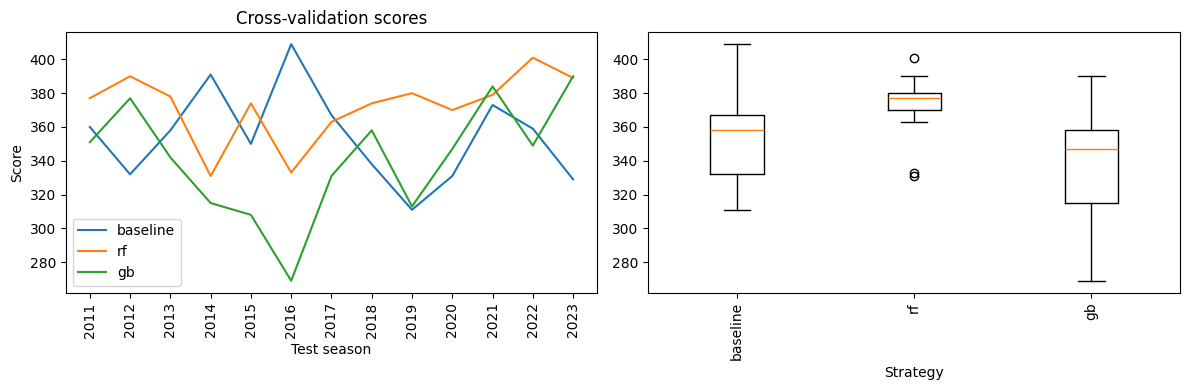

In [12]:
from sklearn.linear_model import BayesianRidge

models = {
    "baseline": StaticEstimator([1, 0]),
    "rf": RoundingEstimator(RandomForestRegressor(
        criterion=rf_study.best_params['criterion'], 
        max_depth=rf_study.best_params['max_depth'], 
        n_estimators=rf_study.best_params['n_estimators'], 
        min_samples_split=rf_study.best_params['min_samples_split']
    )),
    "gb": build_gb_model(gb_study)
}

all_scores = []

for model in models.values():
    print(f"Scoring {model}")
    scores = cross_val_score(model, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    all_scores.append(scores)

all_scores = np.array(all_scores)
labels = models.keys()

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
split_test_seasons = [df_matches.iloc[split[1][0]]["season"] for  split in splits]
axs[0].plot(all_scores.T, label=labels)
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Cross-validation scores")

axs[1].boxplot(all_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=90, ha="center")
fig.tight_layout()
!


In [13]:
model = build_gb_model(gb_study)
train_idx, test_idx = splits[-2]
X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred_raw = model.regressor.predict(X_train)

df_full_train = df_full.iloc[train_idx].copy()
df_full_train["team1Goals_pred"] = y_train_pred[:, 0]
df_full_train["team2Goals_pred"] = y_train_pred[:, 1]
df_full_train["team1Goals_pred_raw"] = y_train_pred_raw[:, 0]
df_full_train["team2Goals_pred_raw"] = y_train_pred_raw[:, 1]
df_full_train[["season", "match_day", "host_name", "guest_name", "host_goals", "guest_goals", "team1Goals_pred", "team2Goals_pred"]]

,season,match_day,host_name,guest_name,host_goals,guest_goals,team1Goals_pred,team2Goals_pred
id,,,,,,,,
9998,2010,1,Bayern,Wolfsburg,2,1,2.0,1.0
10002,2010,1,Hoffenheim,Bremen,4,1,2.0,2.0
10003,2010,1,Gladbach,Nürnberg,1,1,2.0,1.0
10004,2010,1,Köln,Kaiserslautern,1,3,2.0,1.0
10005,2010,1,Freiburg,St. Pauli,1,3,1.0,2.0
...,...,...,...,...,...,...,...,...
61146,2021,34,Gladbach,Hoffenheim,5,1,5.0,1.0
61147,2021,34,Mainz,Frankfurt,2,2,2.0,1.0
61148,2021,34,Stuttgart,Köln,2,1,2.0,1.0


In [14]:
df_full_train[["team1Goals_pred", "team2Goals_pred"]].value_counts()

team1Goals_pred  team2Goals_pred
1.0              1.0                970
2.0              1.0                745
1.0              2.0                412
2.0              2.0                245
3.0              1.0                233
1.0              3.0                146
                 0.0                142
2.0              0.0                141
3.0              0.0                 77
4.0              1.0                 74
0.0              2.0                 67
3.0              2.0                 56
0.0              1.0                 53
2.0              3.0                 42
1.0              4.0                 35
4.0              0.0                 33
0.0              3.0                 31
5.0              1.0                 22
4.0              2.0                 18
2.0              4.0                 17
5.0              0.0                 17
1.0              5.0                 14
3.0              3.0                 13
0.0              4.0                 11
       

# Classification

In [15]:
from sklearn.preprocessing import LabelEncoder


class ClassifierEstimator(BaseEstimator):
    def __init__(self, classifier, max_goals=3, **kwargs) -> None:
        super().__init__()
        self.classifier = classifier
        self.classifier.set_params(**kwargs)
        self.target_encoder = LabelEncoder()
        self.max_goals = max_goals

    @staticmethod
    def clip_results(results: np.ndarray, max_goals=3):
        results = results.copy()
        match_goals = results.sum(axis=1)
        for i, res in enumerate(results):
            while match_goals[i] > max_goals:
                results[i, 0] = np.max((0, results[i, 0] - 1))
                results[i, 1] = np.max((0, results[i, 1] - 1))
                match_goals[i] = results[i, 0] + results[i, 1]
        return results.astype(results.dtype)
    
    def fit(self, X, y):
        y = ClassifierEstimator.clip_results(y, self.max_goals)
        results = [f"{a[0]}:{a[1]}" for a in y]
        self.target_encoder.fit(results)
        results_encoded = self.target_encoder.transform(results)
        self.classifier.fit(X, results_encoded)
    
    def predict(self, X):
        raw = self.classifier.predict(X)
        results = self.target_encoder.inverse_transform(raw)
        y = [[int(a.split(":")[0]), int(a.split(":")[1])] for a in results]
        return np.array(y)
    
    def get_params(self, deep = False):
        params = self.classifier.get_params(deep)
        params["classifier"] = self.classifier
        return params

    def set_params(self, **params):
        self.classifier.set_params(**params)
        return self

In [16]:
def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["gini", "log_loss", "entropy"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 2, 200)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    max_goals = trial.suggest_int('max_goals', 1, 5)
    estimator = ClassifierEstimator(RandomForestClassifier(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=-1
    ), max_goals=max_goals)
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf-classifier", load_if_exists=True)
rf_study.optimize(objective, n_trials=TRIALS)
print(rf_study.best_value, rf_study.best_params)

[I 2024-09-02 18:18:56,447] Using an existing study with name 'rf-classifier' instead of creating a new one.
[I 2024-09-02 18:18:59,404] Trial 1 finished with value: 320.84615384615387 and parameters: {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 159, 'min_samples_split': 91, 'max_goals': 2}. Best is trial 0 with value: 322.84615384615387.


322.84615384615387 {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 76, 'min_samples_split': 87, 'max_goals': 4}


In [17]:

from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 20, 300)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    max_goals = trial.suggest_int('max_goals', 1, 5)
    if algo == "xgb":
        estimator = ClassifierEstimator(XGBClassifier(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["multi:softmax"]),
        ), max_goals=max_goals)
    elif algo == "lgbm":
        estimator = ClassifierEstimator(LGBMClassifier(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["multiclass"]),
        ), max_goals=max_goals)
    elif algo == "gbr":
        estimator = ClassifierEstimator(GradientBoostingClassifier(
            loss=trial.suggest_categorical("objective-gbr", ["log_loss"]),
            alpha=trial.suggest_float("huber-alpha", 0.0, 0.99),
            learning_rate=learning_rate,
            n_estimators = n_estimators,
            subsample=trial.suggest_float("subsample", 0.0, 1.0),
            max_depth = max_depth,
        ), max_goals=max_goals)

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb-classifier", load_if_exists=True)
gb_study.optimize(objective, n_trials=TRIALS)
print(gb_study.best_value, gb_study.best_params)

[I 2024-09-02 18:18:59,436] Using an existing study with name 'gb-classifier' instead of creating a new one.
[I 2024-09-02 18:19:05,689] Trial 1 finished with value: 323.6923076923077 and parameters: {'algo': 'xgb', 'n_estimators': 258, 'max_depth': 3, 'lambda': 0.260843227787674, 'alpha': 0.8953836878981982, 'learning_rate': 0.0014624932004826952, 'num_leaves': 18, 'min_child_weight': 6.371977574774813, 'max_goals': 1, 'objective-xgb': 'multi:softmax'}. Best is trial 0 with value: 329.15384615384613.


329.15384615384613 {'algo': 'xgb', 'n_estimators': 68, 'max_depth': 3, 'lambda': 1.882984811785751, 'alpha': 1.701377802946314, 'learning_rate': 0.09762772774497624, 'num_leaves': 25, 'min_child_weight': 5.784110559882798, 'max_goals': 3, 'objective-xgb': 'multi:softmax'}


In [18]:
def build_gb_model_classifier(study):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda=params["lambda"]
    reg_alpha=params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves=params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    max_goals = params["max_goals"]
    if algo == "xgb":
        estimator = ClassifierEstimator(XGBClassifier(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-xgb"],
        ), max_goals=max_goals)
    elif algo == "lgbm":
        estimator = ClassifierEstimator(LGBMClassifier(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-lgbm"],
        ), max_goals=max_goals)
    return estimator
    

Scoring StaticEstimator(result=[1, 0])
Scoring ClassifierEstimator(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                    classifier=RandomForestClassifier(max_depth=11,
                                                      min_samples_split=87,
                                                      n_estimators=76),
                    criterion='gini', max_depth=11, max_features='sqrt',
                    max_leaf_nodes=None, max_samples=None,
                    min_impurity_decrease=0.0, min_samples_leaf=1,
                    min_samples_split=87, min_weight_fraction_leaf=0.0,
                    monotonic_cst=None, n_estimators=76, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)
Scoring ClassifierEstimator(base_score=None, booster=None, callbacks=None,
                    classifier=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
         

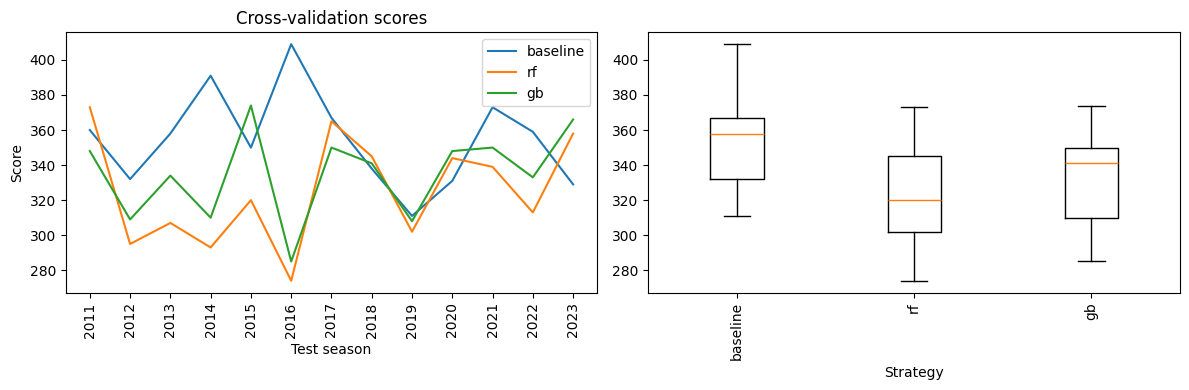

In [19]:
models = {
    "baseline": StaticEstimator([1, 0]),
    "rf": ClassifierEstimator(RandomForestClassifier(
        criterion=rf_study.best_params['criterion'], 
        max_depth=rf_study.best_params['max_depth'], 
        n_estimators=rf_study.best_params['n_estimators'], 
        min_samples_split=rf_study.best_params['min_samples_split']
    ), max_goals=rf_study.best_params["max_goals"]),
    "gb": build_gb_model_classifier(gb_study)
}

all_scores = []

for model in models.values():
    print(f"Scoring {model}")
    scores = cross_val_score(model, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    all_scores.append(scores)

all_scores = np.array(all_scores)
labels = models.keys()

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
split_test_seasons = [df_matches.iloc[split[1][0]]["season"] for  split in splits]
axs[0].plot(all_scores.T, label=labels)
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Cross-validation scores")

axs[1].boxplot(all_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=90, ha="center")
fig.tight_layout()
!